# Hackathon : Reinforcement Learning for Drone Navigation

**TEAM :** Massil'IA

- Delate Etienne
- Bouger Lisa
- Ricart François
- Chachura Baptiste

# **Pistes étudiées :** 

Afin de résoudre ce problème, nous avons exploré plusieurs approches.  

## 1. Exploration des Algorithmes Classiques  

Nous avons commencé par implémenter plusieurs algorithmes classiques d'apprentissage par renforcement : **Q-Learning, Sarsa, Expected Sarsa**, ainsi que des solutions plus algorithmiques comme **A*** et **D***.  

Cependant, ces méthodes se sont révélées inefficaces pour plusieurs raisons :  

- **Limites des approches algorithmiques** : Le problème étant **NP-dur**, la complexité de ces algorithmes devient rapidement ingérable lorsque la taille du problème augmente.  
- **Contraintes des algorithmes de RL** : La principale difficulté vient de la **dimension des états** renvoyés par l’environnement. Ces méthodes reposent sur un dictionnaire associant un score à chaque couple *(état, action)*. Pour obtenir un modèle pertinent, il est nécessaire de visiter chaque état un grand nombre de fois. Or, ici, le **nombre de combinaisons état/action est bien trop élevé** pour que cela soit envisageable.  

## 2. Tentative de Réduction de la Dimensionnalité  

Dans le but d'améliorer l'efficacité des algorithmes de RL, nous avons tenté de réduire la **dimension des états** via un prétraitement.  

- **Réduction initiale** : De **42 à 12** dimensions par agent, en supprimant les informations sur les autres drones. 
- **Deuxième tentative** : Ajustement à **21 dimensions**, en créant une version condensée des états des autres drones. 

Malgré ces efforts, ces modifications **n'ont pas permis d'améliorer les performances** de manière significative.  

## 3. Expérimentation avec d'Autres Algorithmes de RL  

Nous avons ensuite testé d'autres modèles d'apprentissage par renforcement : **ARS, A2C, DQN, HER, PPO**.  

### Adaptation de l'Environnement  

- Étant donné que nous ne pouvions pas modifier l’environnement, nous avons développé un **wrapper** pour le rendre compatible avec **PettingZoo**, une bibliothèque de gestion d’environnements multi-agents.  
- Ensuite, nous avons tenté d'adapter les modèles disponibles dans **Stable-Baselines3**.  
- Cependant, ces modèles étant conçus pour du **mono-agent**, ils ne capturent pas correctement les **dépendances multi-agents**.  

Pour contourner ce problème, nous avons utilisé **SuperSuit**, un package permettant de faire l’interface entre un environnement multi-agent et un modèle mono-agent. Nous avons testé tous les modèles disponibles, mais ceux-ci **n’étaient pas suffisamment performants** pour notre cas.  

### Compatibilité avec TorchRL et Ray RLlib  

Nous avons également tenté de convertir l’environnement pour le rendre compatible avec **TorchRL** et **Ray RLlib**, mais la structure de l’environnement était **trop différente** de celle attendue par ces bibliothèques.  

## 4. Retour à une Approche Classique avec PPO  

Nous sommes finalement revenus à une approche plus classique basée sur **PPO** avec une architecture **acteur-critique** et un **buffer roulant** pour stocker les états au cours de l'épisode.  

### Expérimentation de Différentes Architectures  

Nous avons testé plusieurs architectures de modèles :  

- **Transformers multihead et single-head**  
- **Graph Neural Networks (GNN) avec indexation des états**  
- **Réseaux de neurones profonds avec plusieurs couches fully connected**  

## 5. Optimisationss

Au cours de ces tests, nous avons exploré plusieurs astuces pour améliorer l'entraînement :

- **Normalisation des états** selon différents critères, notamment en ajustant les positions en fonction de la taille de la grille afin d'obtenir des comportements cohérents, quelle que soit sa dimension.  
- **Normalisation de la récompense**, car une récompense trop abrupte peut rendre l'entraînement instable.  
- **Définition algorithmique des actions possibles** à chaque étape pour empêcher le modèle de commettre des erreurs de manière "intentionnelle".  

Cependant, aucune de ces approches n'a conduit à une amélioration significative des performances et elles avaient tendance à ralentir l'entraînement.

### Résultats et Limites  

Nous avons constaté que **complexifier les modèles** ne conduisait pas à une **amélioration significative** des résultats.  

L’une des raisons principales semble être **la fonction de récompense** :  

- L’environnement **appelle la fonction de récompense avec très peu de paramètres**, ce qui limite fortement les possibilités d’amélioration des modèles.  



# **Piste Retenue :**

Comme expliqué précédemment, nous avons opté pour une approche **PPO acteur-critique** en utilisant un **buffer roulant**. Afin de limiter l'impact sur les ressources, nous avons restreint ce buffer à **un seul épisode**.  

En testant de nombreuses configurations, nous avons constaté que les modèles les plus simples obtenaient les meilleures performances. Après de multiples expérimentations, nous avons retenu une **architecture composée de trois couches linéaires de taille 64**.  

Ce choix permet un **entraînement et une inférence ultra rapides**, même sur des **dispositifs très légers**, avec ou sans GPU. De plus, cette architecture minimise la consommation de mémoire RAM et génère des modèles **extrêmement compacts** (45 Ko).  

# **Train :**

In [3]:
%load_ext autoreload
%autoreload 2
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from typing import Tuple, Optional, Dict
import gymnasium as gym
from env import MazeEnv
from simulate import simulation_config , train, evaluate, finetune

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
agent = train()

![](reward_curve_per_episode.png)

In [ ]:
# agent = finetune()

# **Evaluation :**

In [285]:
evacuated_total = 0
all = pd.DataFrame()
for file in os.listdir('eval_configs/'):
    _, agents, config = simulation_config(f'eval_configs/{file}', new_agent=False)
    #turn off warning
    import warnings
    warnings.filterwarnings("ignore")
    agents.actor.load_state_dict(torch.load('./models/actor_best.pth'))
    agents.critic.load_state_dict(torch.load('./models/critic_best.pth'))
    eval_configs = [f'eval_configs/{file}']
    all_results, evacuated = evaluate(configs_paths=eval_configs, trained_agent=agents)
    all = pd.concat([all_results, all], ignore_index=True)
    evacuated_total += evacuated
print("Total evacuated : ",evacuated_total,"/",400)
all.to_csv('all_all_results.csv', index=False)


--- Evaluating Configuration: eval_configs/config_1.json ---
Episode 1/10, Step 18, Reward: 890.00, Evacuated: 4, Deactivated: 0
Episode 2/10, Step 19, Reward: 890.00, Evacuated: 4, Deactivated: 0
Episode 3/10, Step 19, Reward: 840.00, Evacuated: 4, Deactivated: 0
Episode 4/10, Step 18, Reward: 940.00, Evacuated: 4, Deactivated: 0
Episode 5/10, Step 19, Reward: 870.00, Evacuated: 4, Deactivated: 0
Episode 6/10, Step 18, Reward: 880.00, Evacuated: 4, Deactivated: 0
Episode 7/10, Step 17, Reward: 750.00, Evacuated: 3, Deactivated: 1
Episode 8/10, Step 20, Reward: 890.00, Evacuated: 4, Deactivated: 0
Episode 9/10, Step 19, Reward: 910.00, Evacuated: 4, Deactivated: 0
Episode 10/10, Step 18, Reward: 880.00, Evacuated: 3, Deactivated: 1

--- Evaluating Configuration: eval_configs/config_10.json ---
Episode 1/10, Step 19, Reward: 690.00, Evacuated: 0, Deactivated: 4
Episode 2/10, Step 20, Reward: 800.00, Evacuated: 0, Deactivated: 4
Episode 3/10, Step 11, Reward: 470.00, Evacuated: 0, Deact

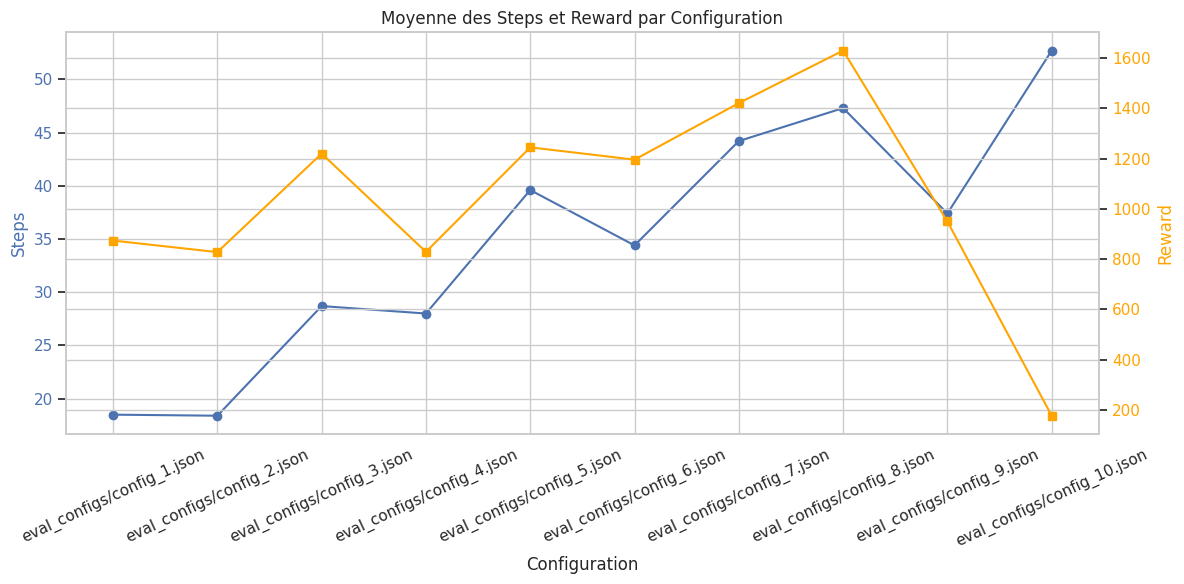

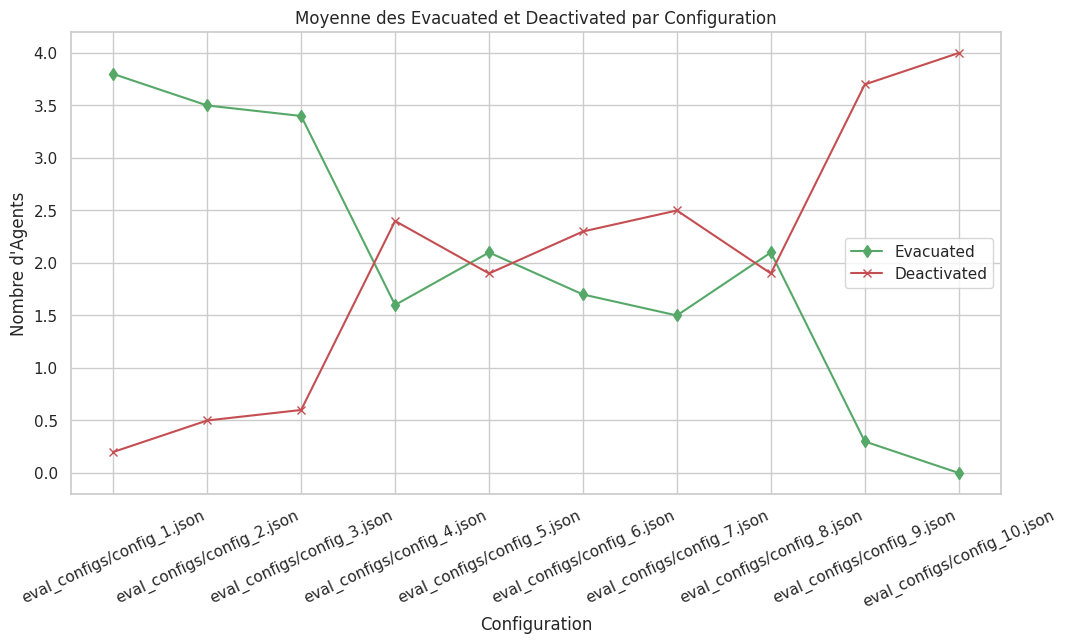

In [328]:
def plot_results(csv_path):

    df = pd.read_csv(csv_path)
    df_mean = df.groupby("config_path").mean().reset_index()
    lastconf_row = df_mean[df_mean["config_path"] == "eval_configs/config_10.json"]
    
    df_mean = pd.concat([df_mean[df_mean["config_path"] != "eval_configs/config_10.json"], lastconf_row], ignore_index=True)
    
    # sns.set(style="whitegrid")
    

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel("Configuration")
    ax1.set_ylabel("Steps", color="b")
    ax1.plot(df_mean["config_path"], df_mean["steps"], label="Steps", marker="o", color="b")
    ax1.tick_params(axis='y', labelcolor="b")
    
    ax2 = ax1.twinx()
    ax2.set_ylabel("Reward", color="orange")
    ax2.plot(df_mean["config_path"], df_mean["reward"], label="Reward", marker="s", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")
    
    for tick in ax1.get_xticklabels():
        tick.set_rotation(25)
    plt.title("Moyenne des Steps et Reward par Configuration")
    fig.tight_layout()
    plt.show()
    
    fig, ax3 = plt.subplots(figsize=(12, 6))
    ax3.set_xlabel("Configuration")
    ax3.set_ylabel("Nombre d'Agents")
    ax3.plot(df_mean["config_path"], df_mean["evacuated"], label="Evacuated", marker="d", color="g")
    ax3.plot(df_mean["config_path"], df_mean["deactivated"], label="Deactivated", marker="x", color="r")
    ax3.legend()
    for tick in ax3.get_xticklabels():
        tick.set_rotation(25)
    plt.title("Moyenne des Evacuated et Deactivated par Configuration")
    plt.show()

csv_path = "all_all_results.csv"

plot_results(csv_path)

# **Test**

In [ ]:
# # pilote agent :

# import  time


# config_path="config.json"
# env, agent, config = simulation_config(config_path,new_agent=True)
# n_agents = env.num_agents

# next_states, info = env.reset()  # (n_agents, obs_dim)

# while True : 
#     time.sleep(1)
#     print(get_possible_actions(next_states[0]))
#     time.sleep(1)
#     actions = [int(input())]

#     next_states, rewards, dones, _ ,info= env.step(actions)  
#     print(next_states)
#     if dones:
#         next_states, info = env.reset()



In [ ]:
# def get_possible_actions(state):
#     x, y, orientation = state[0], state[1], int(state[2])
#     lidar_main_dist, lidar_main_type = state[6], state[7]
#     lidar_right_dist, lidar_right_type = state[8], state[9]
#     lidar_left_dist, lidar_left_type = state[10], state[11]
    
#     possible_actions = {0, 5, 6}  # steady et rotations toujours possibles
    
#     # Déterminer quel lidar correspond à quelle direction dans la grille
#     if orientation == 0:  # Agent orienté vers le haut
#         up,  left, right = (lidar_main_dist, lidar_main_type), (lidar_left_dist, lidar_left_type), (lidar_right_dist, lidar_right_type)
#     elif orientation == 1:  # Agent orienté vers la droite
#         up, down, right = (lidar_left_dist, lidar_left_type), (lidar_right_dist, lidar_right_type), (lidar_main_dist, lidar_main_type)
#     elif orientation == 2:  # Agent orienté vers le bas
#        down, left, right =  (lidar_main_dist, lidar_main_type), (lidar_right_dist, lidar_right_type), (lidar_left_dist, lidar_left_type)
#     else:  # Agent orienté vers la gauche
#         up, down, left  =  (lidar_right_dist, lidar_right_type), (lidar_left_dist, lidar_left_type), (lidar_main_dist, lidar_main_type)


#     # Vérifier les déplacements en fonction des obstacles détectés
#     try : 
#         print("UP ", up)
#         if up[1] == 2 or up[0] > 2:
#             possible_actions.add(1)
#         if up[1] == 0  or up[0] > 1:
#             possible_actions.add(1)  # up (vers le haut de la grille)
#     except :
#         pass
#     try : 
#         print("down : ", down)
#         if down[1] == 2 or down[0] > 2:
#             possible_actions.add(2)
#         if down[1] == 0  or down[0] > 1:
#             possible_actions.add(2)  # down (vers le bas de la grille)
#     except : pass
#     try :
#         print("left :", left)
#         if left[1] == 2 or left[0] > 2:
#             possible_actions.add(3)
#         if left[1] == 0  or left[0] > 1:
#             possible_actions.add(3) # left (vers la gauche de la grille)
#     except: pass
#     try : 
#         print("right : ", right)
#         if right[1] == 2 or right[0] > 2:
#             possible_actions.add(4)
#         if right[1] == 0  or right[0] > 1:
#             possible_actions.add(4) # right (vers la droite de la grille)
#     except : pass
#     return list(possible_actions)
